## Learning both Weights and Connections for Efficient Neural Networks

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.init as init
import copy
import numpy as np
from lenet import LeNet, device, train

In [24]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Resize((32, 32))
    ])

# dataset
train_dataset = datasets.MNIST("./data", train = True, download=True, transform=transform)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST("./data", train=False, download=True, transform=transform)
testloader = DataLoader(test_dataset, shuffle=True)

In [25]:
def test(model):
    row_size = 5
    col_size = 4
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for i, (data, label) in enumerate(testloader):
        plt.subplot(row_size, col_size, i + 1)
        plt.imshow(data.detach().numpy()[0].reshape((28, 28)), cmap='viridis', interpolation='none')
        plt.title(f"{model(data.to(device)).argmax()}")
        plt.xticks([])
        plt.yticks([])
        if i >= row_size * col_size - 1:
            break
            
    plt.tight_layout()
    plt.show()

def calculate_test_accuracy(model):
    total = 0
    correct = 0
    elemwise_correct = [0] * 10
    elemwise_total = [0] * 10
    for i, (data, label) in enumerate(testloader):
        pred = model(data.to(device))
        if label[0] == pred.argmax():
            elemwise_correct[pred.argmax()] += 1
            correct += 1

        total += 1
        elemwise_total[label[0]] += 1
        
    return correct / total, [a / b for a, b in zip(elemwise_correct, elemwise_total)]

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [28]:
pruned_model = LeNet(10) 
model = LeNet(10)

model.load_state_dict(torch.load("./models/letnet.pt")['model_state_dict'])
pruned_model.load_state_dict(torch.load("./models/letnet.pt")['model_state_dict'])
pruned_model.to(device)
model.to(device)

# implementation unstructured pruning 
for name, module in pruned_model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        # prune 90% for convolution
        prune.l1_unstructured(module, name='weight', amount=0.9)
    elif isinstance(module, torch.nn.Linear):
        # prune 90% for FC layers
        prune.l1_unstructured(module, name='weight', amount=0.95)
        
pruned_model.apply(init_weights)

LeNet(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

In [29]:
overall_accuracy, classwise_accuracy = calculate_test_accuracy(model)
overall_accuracy_pruned, classwise_accuracy_pruned = calculate_test_accuracy(pruned_model)

/run/media/imsanskar/My_files/Projects/Pruning/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy before pruning = 0.9891
Accuracy after pruning = 0.2522


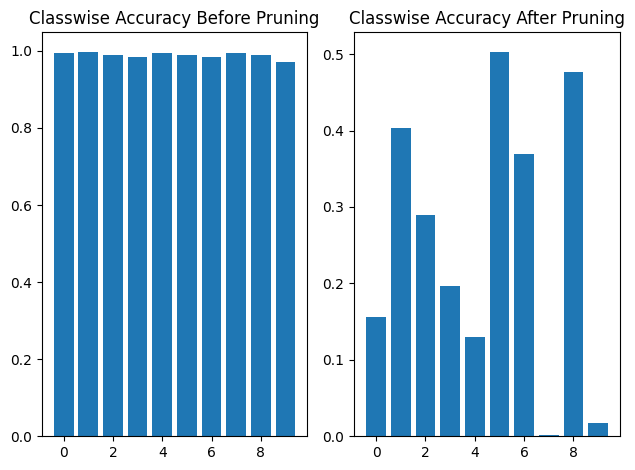

In [30]:
plt.subplot(1, 2, 1)
print(f"Accuracy before pruning = {overall_accuracy}")
plt.bar([i for i in range(10)], classwise_accuracy)
plt.title("Classwise Accuracy Before Pruning")

plt.subplot(1, 2, 2)
print(f"Accuracy after pruning = {overall_accuracy_pruned}")
plt.bar([i for i in range(10)], classwise_accuracy_pruned)
plt.title("Classwise Accuracy After Pruning")
plt.tight_layout()
plt.show()

In [31]:
# retrain the model with pruned parameters
pruned_optimizer = torch.optim.Adam(pruned_model.parameters(), lr=0.01)
train(pruned_model, 10, trainloader, pruned_optimizer)

Epoch: 0 Loss 0 / 938: 2.2757716178894043
Epoch: 1 Loss 0 / 938: 0.35600024461746216
Epoch: 2 Loss 0 / 938: 0.13384504616260529
Epoch: 3 Loss 0 / 938: 0.1888059675693512
Epoch: 4 Loss 0 / 938: 0.004131856840103865
Epoch: 5 Loss 0 / 938: 0.06088653951883316
Epoch: 6 Loss 0 / 938: 0.03382798284292221
Epoch: 7 Loss 0 / 938: 0.05783500522375107
Epoch: 8 Loss 0 / 938: 0.02133745700120926
Epoch: 9 Loss 0 / 938: 0.040378388017416


In [ ]:
overall_accuracy, classwise_accuracy = calculate_test_accuracy(model)
overall_accuracy_pruned, classwise_accuracy_pruned = calculate_test_accuracy(pruned_model)

plt.subplot(1, 2, 1)
print(f"Accuracy before pruning = {overall_accuracy}")
plt.bar([i for i in range(10)], classwise_accuracy)
plt.title("Classwise Accuracy Before Pruning")

plt.subplot(1, 2, 2)
print(f"Accuracy before pruning = {overall_accuracy_pruned}")
plt.bar([i for i in range(10)], classwise_accuracy_pruned)
plt.title("Classwise Accuracy After Pruning")

plt.show()

In [ ]:
total_params = 0
unpruned_params = 0

for name, module in pruned_model.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        weight = getattr(module, 'weight')
        total_params += weight.numel()
        unpruned_params += torch.sum(weight != 0).item()

print(f"Total parameters: {total_params}")
print(f"Unpruned parameters: {unpruned_params}")

In [ ]:
torch.save({
    'epoch': 10,
    'model_state_dict': pruned_model.state_dict(),
    'optimizer_state_dict': pruned_optimizer.state_dict(),            
}, "./models/pruned_letnet.pt")